In [1]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np
import ast
import torch.nn as nn
import torch.optim as optim
import random
from matplotlib import pyplot as plt
import os
from datetime import datetime
import global_vars

In [2]:
# 方便复现结果
def set_all_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # 如果使用 GPU，也需要固定 CUDA 的随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 如果有多个 GPU
set_all_seed(42)

In [3]:
# 前25个特征是离散特征，后13个特征是连续特征
df_train=pd.read_csv("data/exp1/raw_train.csv")
df_test=pd.read_csv("data/exp1/raw_test.csv")

In [4]:
df_train['vectorized_features_1'] = df_train['vectorized_features_1'].apply(ast.literal_eval)
df_test['vectorized_features_1'] = df_test['vectorized_features_1'].apply(ast.literal_eval)

In [5]:
# 获取训练数据
x_train=torch.from_numpy(np.array(df_train['vectorized_features_1'].values.tolist(),np.float32))
x_train_d=x_train[:,:25].long() # 前25维是离散变量(discrete)，要转为long类型才能送入embedding层
x_train_c=x_train[:,25:] # 中间13维是连续变量(continuous), 最后一维是0或1，也当做连续变量
y1_train=torch.from_numpy(np.array(df_train['income'].values.tolist(),np.float32))
y2_train=torch.from_numpy(np.array(df_train['AMARITL'].values.tolist(),np.float32))

print(x_train_d)
print(x_train_d.shape)
print(x_train_c)
print(x_train_c.shape)
print(y1_train)
print(y1_train.shape)
print(y2_train)
print(y2_train.shape)

tensor([[2, 6, 6,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 5,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [5, 7, 3,  ..., 0, 0, 0]])
torch.Size([95130, 25])
tensor([[58.,  4., 34.,  ..., 52., 94.,  0.],
        [ 9.,  0.,  0.,  ...,  0., 94.,  0.],
        [10.,  0.,  0.,  ...,  0., 94.,  0.],
        ...,
        [51., 33., 19.,  ..., 52., 94.,  0.],
        [ 3.,  0.,  0.,  ...,  0., 94.,  0.],
        [65., 37.,  2.,  ..., 52., 94.,  0.]])
torch.Size([95130, 14])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([95130])
tensor([0., 1., 1.,  ..., 0., 1., 0.])
torch.Size([95130])


计算两个任务的标签间的pearson相关系数

In [6]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(y1_train, y2_train)
print(f"Absolute Pearson correlation coefficient: {abs(corr)}") # 符合原论文的0.1768
print(f"P-value: {p_value}")

Absolute Pearson correlation coefficient: 0.17716269850240274
P-value: 0.0


In [7]:
# 获取测试数据
x_test=torch.from_numpy(np.array(df_test['vectorized_features_1'].values.tolist(),np.float32))
x_test_d=x_test[:,:25].long() # 前25维是离散变量(discrete)，要转为long类型才能送入embedding层
x_test_c=x_test[:,25:] # 中间13维是连续变量(continuous), 最后一维是0或1，也当做连续变量
y1_test=torch.from_numpy(np.array(df_test['income'].values.tolist(),np.float32))
y2_test=torch.from_numpy(np.array(df_test['AMARITL'].values.tolist(),np.float32))

print(x_test_d)
print(x_test_d.shape)
print(x_test_c)
print(x_test_c.shape)
print(y1_test)
print(y1_test.shape)
print(y2_test)
print(y2_test.shape)

tensor([[ 1,  9,  4,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 1,  3,  1,  ...,  0,  0,  0],
        [ 2, 14, 10,  ...,  1,  2,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]])
torch.Size([47391, 25])
tensor([[35., 29.,  3.,  ..., 52., 94.,  0.],
        [13.,  0.,  0.,  ...,  0., 94.,  0.],
        [ 1.,  0.,  0.,  ...,  0., 94.,  0.],
        ...,
        [22., 43., 26.,  ..., 52., 94.,  1.],
        [24.,  1., 43.,  ..., 52., 94.,  0.],
        [67.,  0.,  0.,  ...,  0., 94.,  0.]])
torch.Size([47391, 14])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([47391])
tensor([0., 1., 1.,  ..., 1., 0., 0.])
torch.Size([47391])


In [8]:
class MyDataset(Dataset):
    def __init__(self,x_discrete,x_continuous,y1,y2):
        self.x_d=x_discrete
        self.x_c=x_continuous
        self.y1=y1
        self.y2=y2
    def __len__(self):
        return self.x_d.shape[0]
    def __getitem__(self,idx):
        return (self.x_d[idx],self.x_c[idx],self.y1[idx],self.y2[idx])

In [9]:
# 训练集
train_dataset=MyDataset(x_train_d,x_train_c,y1_train,y2_train)
# 验证集和测试集按照原论文1:1
val_dataset=MyDataset(x_test_d[:23695],x_test_c[:23695],y1_test[:23695],y2_test[:23695])
test_dataset=MyDataset(x_test_d[23695:47390],x_test_c[23695:47390],y1_test[23695:47390],y2_test[23695:47390])

In [10]:
from SparseMMoE import SparseMMoE

In [11]:
class MyModel(nn.Module):
    # feature_dim:输入数据的维数  expert_dim:每个神经元输出的维数  n_expert:专家数量  n_task:任务数(gate数)
    def __init__(self, feature_dim, expert_dim, n_expert, n_activated_expert, n_task, tower_dropout=0, expert_dropout=0):
        super(MyModel, self).__init__()

        self.n_task = n_task

        self.sparse_mmoe = SparseMMoE(input_size=feature_dim,
                                     output_size=expert_dim,
                                     num_experts=n_expert,
                                     n_task=n_task,
                                     expert_dropout=expert_dropout,
                                     noisy_gating=True,
                                     k=n_activated_expert)

        # 对于离散变量做embedding
        # 25种离散变量
        vocab_size_list = [9,24,15,5,10,2,3,6,1,6,6,50,37,8,9,8,9,3,3,5,40,40,41,5,3]
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=i, embedding_dim=4) for i in vocab_size_list
        ])
        # 合计送入expert的维度为:25*4+14=114

        # 顶层的任务塔
        hidden_layer1 = [64, 32]
        self.towers=nn.ModuleList([
            nn.Sequential(
                nn.Linear(expert_dim, hidden_layer1[0]),
                nn.ReLU(),
                nn.Linear(hidden_layer1[0], hidden_layer1[1]),
                nn.ReLU(),
                nn.Dropout(tower_dropout),
                nn.Linear(hidden_layer1[1], 1))
            for i in range(n_task)
        ])
        
        self.sigmoid=nn.Sigmoid()

    def forward(self, x_d, x_c):
        temp = []
        for i in range(len(self.embeddings)):
            temp.append(self.embeddings[i](x_d[:, i]))
        temp = temp + [x_c]
        x = torch.cat(temp, dim=-1)

        towers_input, load_balancing_loss = self.sparse_mmoe(x)

        outputs = []
        for i in range(self.n_task):
            outputs.append(self.sigmoid(self.towers[i](towers_input[i])))

        return outputs, load_balancing_loss

In [12]:
# model config
feature_dim=114
expert_dim=32
n_expert=16
n_activated_expert=4
n_task=2
tower_dropout=0
expert_dropout=0

In [13]:
mymodel = MyModel(feature_dim=feature_dim,
                  expert_dim=expert_dim,
                  n_expert=n_expert,
                  n_activated_expert=n_activated_expert,
                  n_task=n_task, 
                  expert_dropout=expert_dropout, 
                  tower_dropout=tower_dropout)

nParams = sum([p.nelement() for p in mymodel.parameters()])
print('Number of parameters: %d' % nParams)

nParams_in_mmoe=0
for name,p in mymodel.named_parameters():
    if name.startswith("sparse_mmoe"):
        nParams_in_mmoe=nParams_in_mmoe+p.nelement()
print('Number of parameters in SparseMMoE: %d' % nParams_in_mmoe)
# 相比于MMOE增加了w_noises和b_noises
print(f'Number of activated parameters in SparseMMoE: {int(nParams_in_mmoe*n_activated_expert/n_expert)}')

Number of parameters: 185138
Number of parameters in SparseMMoE: 175296
Number of activated parameters in SparseMMoE: 43824


In [14]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [15]:
if not os.path.exists("model/exp1_SparseMMoE/"):
    os.makedirs("model/exp1_SparseMMoE/") 

In [16]:
def train(mymodel, lr, N_epochs, batch_size):
    global writer
    log_dir = os.path.join("logs/exp1_SparseMMoE", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    writer = SummaryWriter(log_dir=log_dir)
    global_vars.writer=writer # 用于给python文件传递全局变量
    global tot_iters
    tot_iters = 0
    global_vars.tot_iters=tot_iters # 用于给python文件传递全局变量
    mymodel = mymodel.to(device)
    loss_fun = nn.BCELoss()
    optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)
    adam_batch_loss = []
    losses = []
    val_losses = []
    best_loss = float("inf")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(N_epochs):
        # train loop
        batch_loss = []
        mymodel.train()
        for x_d_batch, x_c_batch, y1_batch, y2_batch in train_dataloader:
            tot_iters+=1
            global_vars.tot_iters+=1 # tot_iters是int，为不可变对象，所以tot_iters+=1不会修改global_vars.tot_iters
            
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            [y1_pred, y2_pred], load_balancing_loss = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)
            
            loss1 = loss_fun(y1_pred, y1_batch)
            loss2 = loss_fun(y2_pred, y2_batch)
            writer.add_scalar(f"loss1", loss1, tot_iters)
            writer.add_scalar(f"loss2", loss2, tot_iters)
            writer.add_scalar(f"load_balancing_loss", load_balancing_loss, tot_iters)
            loss = loss1+loss2+load_balancing_loss  # 此处令两个任务的损失值权重均为1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record result
            adam_batch_loss.append(loss.detach().cpu().numpy())
            batch_loss.append(loss.detach().cpu().numpy())

        # val loop
        val_batch_loss = []
        mymodel.eval()
        for x_d_batch, x_c_batch, y1_batch, y2_batch in val_dataloader:
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            [y1_pred, y2_pred], load_balancing_loss = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)

            loss = loss_fun(y1_pred, y1_batch) + loss_fun(y2_pred, y2_batch)+load_balancing_loss

            # record result
            val_batch_loss.append(loss.detach().cpu().numpy())

        # post processing
        losses.append(np.mean(np.array(batch_loss)))
        val_losses.append(np.mean(np.array(val_batch_loss)))

        # print progress
        print(f"Epoch={epoch},train_loss={losses[-1]},val_loss={val_losses[-1]}")
        writer.add_scalar(f"train_loss", losses[-1], epoch)
        writer.add_scalar(f"val_loss", val_losses[-1], epoch)

        # save best model
        if (val_losses[-1] < best_loss):
            print("current epoch is the best so far. Saving model...")
            torch.save(mymodel.state_dict(), f'model/exp1_SparseMMoE/best_model_{lr}_{N_epochs}_{batch_size}_{expert_dropout}_{tower_dropout}')
            best_loss = val_losses[-1]
    
    writer.close() # writer是可变对象，关闭writer就是关闭global_vars.writer

    return losses, val_losses, adam_batch_loss

In [17]:
batch_size=256
N_epochs=50
lr=0.0001

In [18]:
losses, val_losses, adam_batch_loss= train(mymodel=mymodel, lr=lr, N_epochs=N_epochs, batch_size=batch_size)

Epoch=0,train_loss=0.6316223740577698,val_loss=0.43853485584259033
current epoch is the best so far. Saving model...
Epoch=1,train_loss=0.3942098617553711,val_loss=0.35843634605407715
current epoch is the best so far. Saving model...
Epoch=2,train_loss=0.34879592061042786,val_loss=0.33606618642807007
current epoch is the best so far. Saving model...
Epoch=3,train_loss=0.33529987931251526,val_loss=0.33091139793395996
current epoch is the best so far. Saving model...
Epoch=4,train_loss=0.3231922686100006,val_loss=0.3263666033744812
current epoch is the best so far. Saving model...
Epoch=5,train_loss=0.31714290380477905,val_loss=0.3189408779144287
current epoch is the best so far. Saving model...
Epoch=6,train_loss=0.302437961101532,val_loss=0.3004225790500641
current epoch is the best so far. Saving model...
Epoch=7,train_loss=0.2936355769634247,val_loss=0.29921993613243103
current epoch is the best so far. Saving model...
Epoch=8,train_loss=0.29490333795547485,val_loss=0.284181773662567

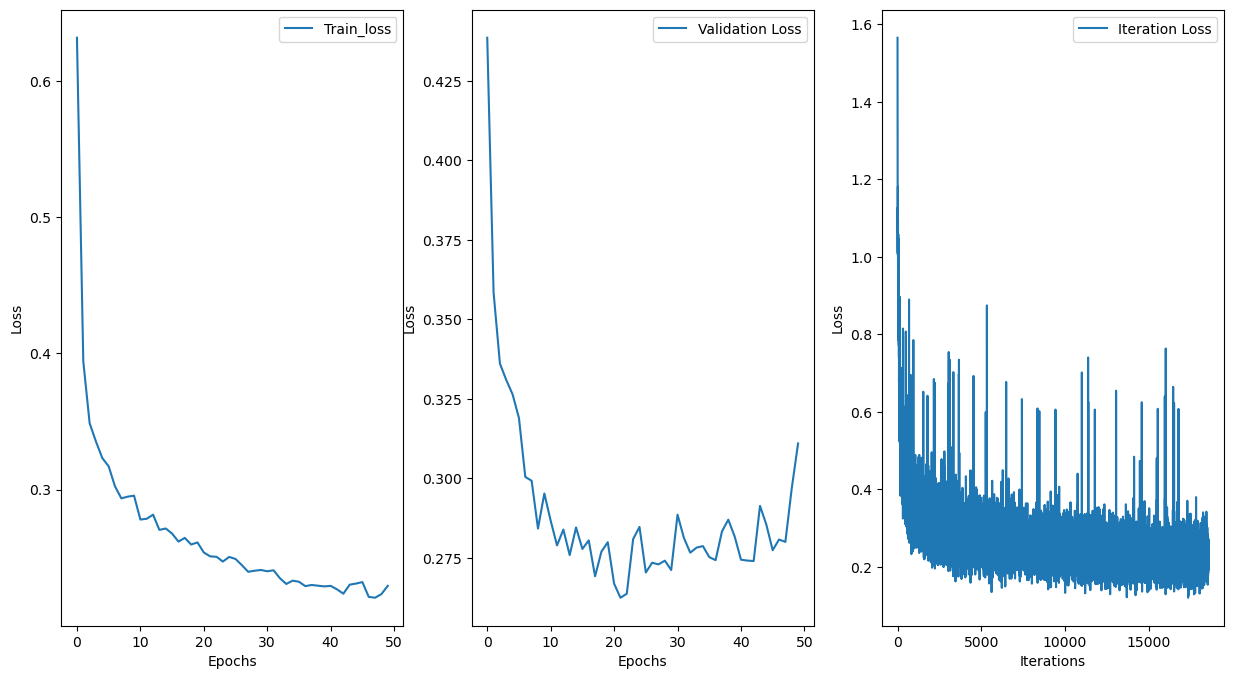

In [19]:
# visualization
fix,axes=plt.subplots(nrows=1,ncols=3,figsize=(15, 8))

axes[0].plot(range(N_epochs),losses,label="Train_loss")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# axes[1].plot(range(N_epochs),best_model_loss[0],label="Train Loss")
# Validation loss is stable here 
axes[1].plot(range(N_epochs),val_losses,label="Validation Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(range(tot_iters),adam_batch_loss,label="Iteration Loss")
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Loss')
axes[2].legend()

In [23]:
# load best model based on validation
mybestmodel=MyModel(feature_dim=feature_dim,
                  expert_dim=expert_dim,
                  n_expert=n_expert,
                  n_activated_expert=n_activated_expert,
                  n_task=n_task, 
                  expert_dropout=expert_dropout, 
                  tower_dropout=tower_dropout)
mybestmodel.load_state_dict(torch.load(f'model/exp1_SparseMMoE/best_model_{lr}_{N_epochs}_{batch_size}_{expert_dropout}_{tower_dropout}'))
mybestmodel=mybestmodel.to(device)

x_test_d, x_test_c=x_test_d.to(device), x_test_c.to(device)

[y1_pred, y2_pred], load_balancing_loss = mybestmodel(x_test_d[23695:47390],x_test_c[23695:47390])

# y1_pred=(y1_pred>0.5).int()
# y2_pred=(y2_pred>0.5).int()

y1_pred=y1_pred.squeeze(1).detach().cpu().numpy()
y2_pred=y2_pred.squeeze(1).detach().cpu().numpy()

In [24]:
from sklearn.metrics import roc_curve, auc

def get_auc(y_true,y_pred):
    # 获取 ROC 曲线
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # 计算 AUC
    calculated_auc = auc(fpr, tpr)
    print(f"Custom AUC: {calculated_auc}")
    return calculated_auc

In [25]:
auc1=get_auc(y1_test[23695:47390],y1_pred)
auc2=get_auc(y2_test[23695:47390],y2_pred)

Custom AUC: 0.9358949591319135
Custom AUC: 0.9896459197417868


In [26]:
y1_test[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
y1_pred[:10]

array([1.7202473e-01, 6.2864088e-02, 1.2952536e-06, 3.2487733e-06,
       1.1685855e-03, 1.2817708e-02, 8.3745355e-03, 9.6175887e-02,
       1.7331112e-03, 7.1839942e-04], dtype=float32)

In [28]:
y2_pred[:10]

array([1.6229131e-05, 2.0046675e-01, 9.9999893e-01, 9.9994183e-01,
       9.9653471e-01, 5.1455900e-05, 4.9308159e-07, 1.3727871e-01,
       9.1105983e-02, 1.4465865e-01], dtype=float32)

In [29]:
y2_test[:10]

tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])